# Hard Negatives Experiment

This notebook compares two negative sampling strategies:
1. **Standard**: Shuffle all intermediate nodes (existing approach)
2. **Hard**: Replace only one random intermediate node (new approach)

The hypothesis is that hard negatives are more challenging and may help the model learn more robust features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Import path_embedding modules
from path_embedding.data.drugmechdb import load_drugmechdb
from path_embedding.utils.path_extraction import build_multigraph, extract_paths
from path_embedding.data.negative_sampling import generate_negatives, generate_hard_negatives
from path_embedding.embedding.openai_embedder import load_api_key, embed_paths
from path_embedding.model.classifier import train_classifier
from path_embedding.model.data_split import split_by_indication

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Configuration

In [2]:
# Paths
DATA_PATH = "../data/indication_paths.yaml"
API_KEY_PATH = "/Users/jtr4v/openai.key.another"

# Parameters
MAX_PATHS_PER_INDICATION = 10
TEST_SIZE = 0.2
RANDOM_SEED = 42

## 1. Load and Prepare Data

In [3]:
print("Loading DrugMechDB data...")
indications = load_drugmechdb(DATA_PATH)
print(f"Loaded {len(indications)} indications")

Loading DrugMechDB data...


Loaded 4846 indications


In [4]:
print("Extracting paths from multigraphs...")
all_positive_paths = []
skipped_count = 0

for indication in indications:
    graph = build_multigraph(indication)
    try:
        paths = extract_paths(graph, indication["graph"]["_id"], max_paths=MAX_PATHS_PER_INDICATION)
        all_positive_paths.extend(paths)
    except ValueError:
        skipped_count += 1

print(f"Extracted {len(all_positive_paths)} positive paths (skipped {skipped_count} invalid indications)")

Extracting paths from multigraphs...


Extracted 9528 positive paths (skipped 29 invalid indications)


In [5]:
print("Splitting train/test by indication...")
train_pos, test_pos = split_by_indication(all_positive_paths, test_size=TEST_SIZE, random_seed=RANDOM_SEED)
print(f"Split: {len(train_pos)} train positive, {len(test_pos)} test positive")

Splitting train/test by indication...
Split: 7617 train positive, 1911 test positive


## 2. Experiment 1: Standard Negatives (Baseline)

Generate negatives using the existing approach (shuffle all intermediate nodes).

In [6]:
print("="*70)
print("EXPERIMENT 1: STANDARD NEGATIVES (SHUFFLE ALL NODES)")
print("="*70)

print("\nGenerating standard negatives...")
train_neg_standard = generate_negatives(train_pos)
test_neg_standard = generate_negatives(test_pos)
print(f"Generated {len(train_neg_standard)} train negatives, {len(test_neg_standard)} test negatives")

train_paths_standard = train_pos + train_neg_standard
test_paths_standard = test_pos + test_neg_standard

train_labels_standard = np.array([1] * len(train_pos) + [0] * len(train_neg_standard))
test_labels_standard = np.array([1] * len(test_pos) + [0] * len(test_neg_standard))

print(f"Train: {len(train_paths_standard)} paths ({len(train_pos)} pos, {len(train_neg_standard)} neg)")
print(f"Test: {len(test_paths_standard)} paths ({len(test_pos)} pos, {len(test_neg_standard)} neg)")

EXPERIMENT 1: STANDARD NEGATIVES (SHUFFLE ALL NODES)

Generating standard negatives...


Generated 7617 train negatives, 1911 test negatives
Train: 15234 paths (7617 pos, 7617 neg)
Test: 3822 paths (1911 pos, 1911 neg)


In [7]:
print("\nLoading API key...")
api_key = load_api_key(API_KEY_PATH)

print("Generating embeddings for standard negatives (train)...")
train_embeddings_standard = embed_paths(train_paths_standard, api_key)
print(f"Train embeddings shape: {train_embeddings_standard.shape}")

print("Generating embeddings for standard negatives (test)...")
test_embeddings_standard = embed_paths(test_paths_standard, api_key)
print(f"Test embeddings shape: {test_embeddings_standard.shape}")


Loading API key...
Generating embeddings for standard negatives (train)...


Processing batch 1/8 (2048 paths)...


Processing batch 2/8 (2048 paths)...


Processing batch 3/8 (2048 paths)...


Processing batch 4/8 (2048 paths)...


Processing batch 5/8 (2048 paths)...


Processing batch 6/8 (2048 paths)...


Processing batch 7/8 (2048 paths)...


Processing batch 8/8 (898 paths)...


Train embeddings shape: (15234, 1536)
Generating embeddings for standard negatives (test)...


Processing batch 1/2 (2048 paths)...


Processing batch 2/2 (1774 paths)...


Test embeddings shape: (3822, 1536)


In [8]:
print("\nTraining Random Forest classifier...")
rf_model_standard = train_classifier(train_embeddings_standard, train_labels_standard, random_state=RANDOM_SEED)

print("Evaluating on test set...")
rf_predictions_standard = rf_model_standard.predict(test_embeddings_standard)
rf_probabilities_standard = rf_model_standard.predict_proba(test_embeddings_standard)[:, 1]

# Calculate metrics
standard_results = {
    'accuracy': accuracy_score(test_labels_standard, rf_predictions_standard),
    'precision': precision_score(test_labels_standard, rf_predictions_standard),
    'recall': recall_score(test_labels_standard, rf_predictions_standard),
    'f1': f1_score(test_labels_standard, rf_predictions_standard),
    'roc_auc': roc_auc_score(test_labels_standard, rf_probabilities_standard)
}

print("\nStandard Negatives Results:")
for metric, value in standard_results.items():
    print(f"  {metric}: {value:.4f}")


Training Random Forest classifier...


Evaluating on test set...

Standard Negatives Results:
  accuracy: 0.8828
  precision: 0.9246
  recall: 0.8336
  f1: 0.8767
  roc_auc: 0.9608


## 3. Experiment 2: Hard Negatives

Generate negatives using the new approach (replace only one node).

In [9]:
print("="*70)
print("EXPERIMENT 2: HARD NEGATIVES (REPLACE ONE NODE)")
print("="*70)

print("\nGenerating hard negatives...")
train_neg_hard = generate_hard_negatives(train_pos)
test_neg_hard = generate_hard_negatives(test_pos)
print(f"Generated {len(train_neg_hard)} train negatives, {len(test_neg_hard)} test negatives")

train_paths_hard = train_pos + train_neg_hard
test_paths_hard = test_pos + test_neg_hard

train_labels_hard = np.array([1] * len(train_pos) + [0] * len(train_neg_hard))
test_labels_hard = np.array([1] * len(test_pos) + [0] * len(test_neg_hard))

print(f"Train: {len(train_paths_hard)} paths ({len(train_pos)} pos, {len(train_neg_hard)} neg)")
print(f"Test: {len(test_paths_hard)} paths ({len(test_pos)} pos, {len(test_neg_hard)} neg)")

EXPERIMENT 2: HARD NEGATIVES (REPLACE ONE NODE)

Generating hard negatives...


Generated 7617 train negatives, 1911 test negatives
Train: 15234 paths (7617 pos, 7617 neg)
Test: 3822 paths (1911 pos, 1911 neg)


In [10]:
print("\nGenerating embeddings for hard negatives (train)...")
train_embeddings_hard = embed_paths(train_paths_hard, api_key)
print(f"Train embeddings shape: {train_embeddings_hard.shape}")

print("Generating embeddings for hard negatives (test)...")
test_embeddings_hard = embed_paths(test_paths_hard, api_key)
print(f"Test embeddings shape: {test_embeddings_hard.shape}")


Generating embeddings for hard negatives (train)...


Processing batch 1/8 (2048 paths)...


Processing batch 2/8 (2048 paths)...


Processing batch 3/8 (2048 paths)...


Processing batch 4/8 (2048 paths)...


Processing batch 5/8 (2048 paths)...


Processing batch 6/8 (2048 paths)...


Processing batch 7/8 (2048 paths)...


Processing batch 8/8 (898 paths)...


Train embeddings shape: (15234, 1536)
Generating embeddings for hard negatives (test)...


Processing batch 1/2 (2048 paths)...


Processing batch 2/2 (1774 paths)...


Test embeddings shape: (3822, 1536)


In [11]:
print("\nTraining Random Forest classifier...")
rf_model_hard = train_classifier(train_embeddings_hard, train_labels_hard, random_state=RANDOM_SEED)

print("Evaluating on test set...")
rf_predictions_hard = rf_model_hard.predict(test_embeddings_hard)
rf_probabilities_hard = rf_model_hard.predict_proba(test_embeddings_hard)[:, 1]

# Calculate metrics
hard_results = {
    'accuracy': accuracy_score(test_labels_hard, rf_predictions_hard),
    'precision': precision_score(test_labels_hard, rf_predictions_hard),
    'recall': recall_score(test_labels_hard, rf_predictions_hard),
    'f1': f1_score(test_labels_hard, rf_predictions_hard),
    'roc_auc': roc_auc_score(test_labels_hard, rf_probabilities_hard)
}

print("\nHard Negatives Results:")
for metric, value in hard_results.items():
    print(f"  {metric}: {value:.4f}")


Training Random Forest classifier...


Evaluating on test set...

Hard Negatives Results:
  accuracy: 0.6805
  precision: 0.7363
  recall: 0.5625
  f1: 0.6378
  roc_auc: 0.7500


## 4. Comparison & Analysis

In [12]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Standard Negatives': standard_results,
    'Hard Negatives': hard_results
})

comparison_df['Difference'] = comparison_df['Standard Negatives'] - comparison_df['Hard Negatives']

print("\n" + "="*70)
print("COMPARISON: STANDARD VS HARD NEGATIVES")
print("="*70)
print(comparison_df.round(4))
print("\nNote: Positive difference means standard negatives are easier to classify")


COMPARISON: STANDARD VS HARD NEGATIVES
           Standard Negatives  Hard Negatives  Difference
accuracy               0.8828          0.6805      0.2023
precision              0.9246          0.7363      0.1882
recall                 0.8336          0.5625      0.2711
f1                     0.8767          0.6378      0.2389
roc_auc                0.9608          0.7500      0.2108

Note: Positive difference means standard negatives are easier to classify


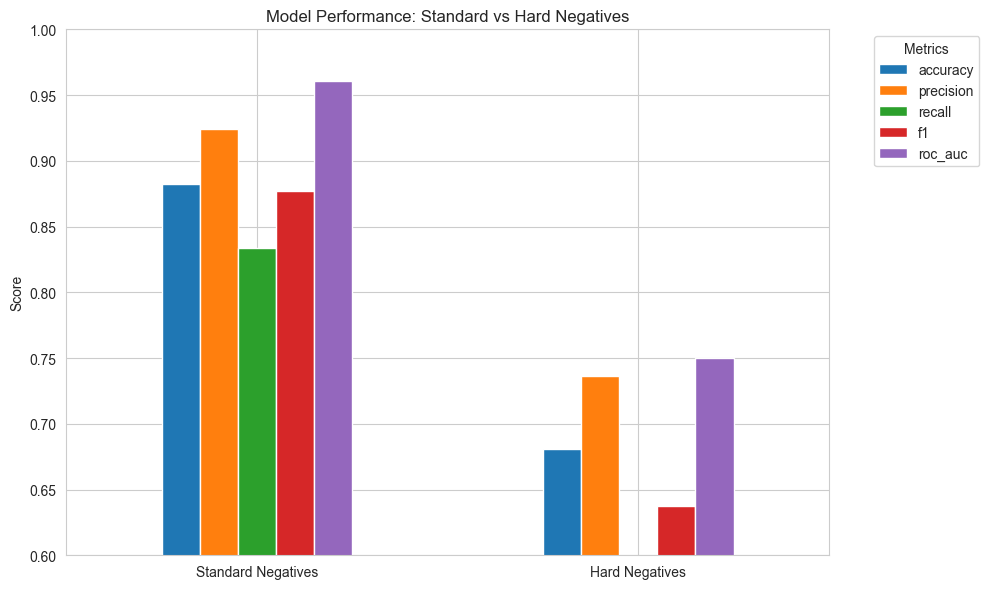

In [13]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
comparison_df[['Standard Negatives', 'Hard Negatives']].T.plot(kind='bar', ax=ax)
ax.set_ylabel('Score')
ax.set_title('Model Performance: Standard vs Hard Negatives')
ax.set_xticklabels(['Standard Negatives', 'Hard Negatives'], rotation=0)
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([0.6, 1.0])
plt.tight_layout()
plt.show()

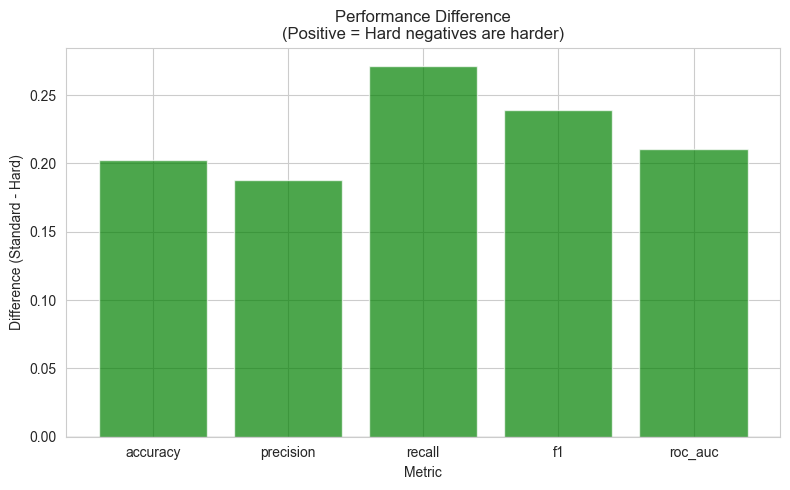

In [14]:
# Plot difficulty difference
fig, ax = plt.subplots(figsize=(8, 5))
metrics = list(standard_results.keys())
differences = [comparison_df.loc[m, 'Difference'] for m in metrics]
colors = ['green' if d > 0 else 'red' for d in differences]

ax.bar(metrics, differences, color=colors, alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_ylabel('Difference (Standard - Hard)')
ax.set_title('Performance Difference\n(Positive = Hard negatives are harder)')
ax.set_xlabel('Metric')
plt.tight_layout()
plt.show()

## 5. Error Analysis

In [15]:
print("="*70)
print("ERROR ANALYSIS")
print("="*70)

# Standard negatives errors
standard_errors = test_labels_standard != rf_predictions_standard
standard_false_positives = (test_labels_standard == 0) & (rf_predictions_standard == 1)
standard_false_negatives = (test_labels_standard == 1) & (rf_predictions_standard == 0)

print("\nStandard Negatives:")
print(f"  Total errors: {standard_errors.sum()} / {len(test_labels_standard)} ({standard_errors.sum()/len(test_labels_standard)*100:.2f}%)")
print(f"  False positives: {standard_false_positives.sum()}")
print(f"  False negatives: {standard_false_negatives.sum()}")

# Hard negatives errors
hard_errors = test_labels_hard != rf_predictions_hard
hard_false_positives = (test_labels_hard == 0) & (rf_predictions_hard == 1)
hard_false_negatives = (test_labels_hard == 1) & (rf_predictions_hard == 0)

print("\nHard Negatives:")
print(f"  Total errors: {hard_errors.sum()} / {len(test_labels_hard)} ({hard_errors.sum()/len(test_labels_hard)*100:.2f}%)")
print(f"  False positives: {hard_false_positives.sum()}")
print(f"  False negatives: {hard_false_negatives.sum()}")

ERROR ANALYSIS

Standard Negatives:
  Total errors: 448 / 3822 (11.72%)
  False positives: 130
  False negatives: 318

Hard Negatives:
  Total errors: 1221 / 3822 (31.95%)
  False positives: 385
  False negatives: 836


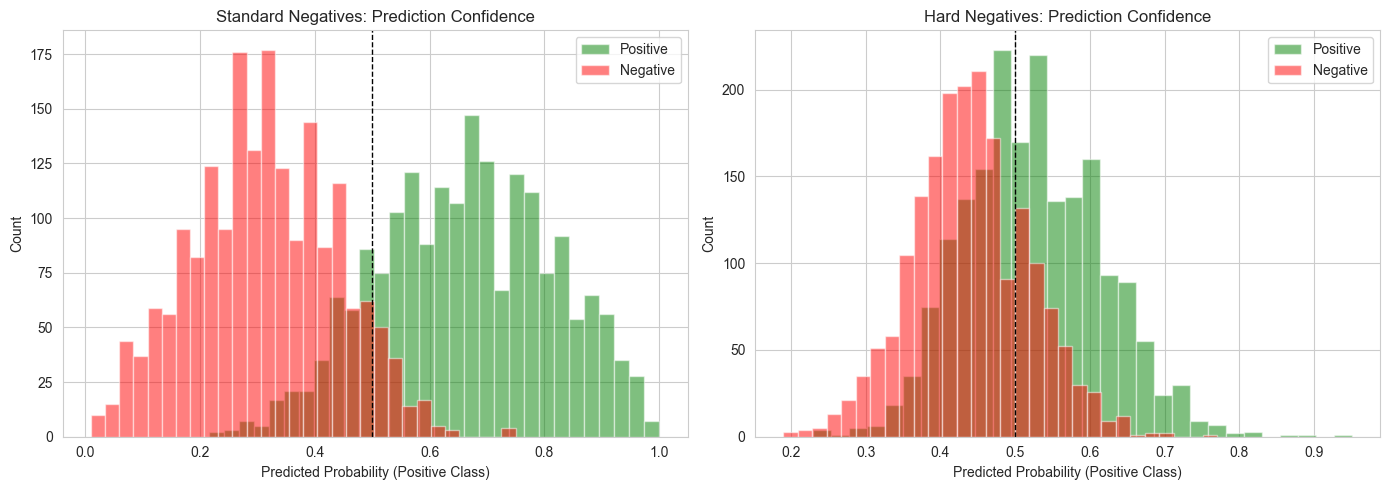

In [16]:
# Compare prediction confidence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Standard negatives
axes[0].hist(rf_probabilities_standard[test_labels_standard == 1], bins=30, alpha=0.5, label='Positive', color='green')
axes[0].hist(rf_probabilities_standard[test_labels_standard == 0], bins=30, alpha=0.5, label='Negative', color='red')
axes[0].set_xlabel('Predicted Probability (Positive Class)')
axes[0].set_ylabel('Count')
axes[0].set_title('Standard Negatives: Prediction Confidence')
axes[0].legend()
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=1)

# Hard negatives
axes[1].hist(rf_probabilities_hard[test_labels_hard == 1], bins=30, alpha=0.5, label='Positive', color='green')
axes[1].hist(rf_probabilities_hard[test_labels_hard == 0], bins=30, alpha=0.5, label='Negative', color='red')
axes[1].set_xlabel('Predicted Probability (Positive Class)')
axes[1].set_ylabel('Count')
axes[1].set_title('Hard Negatives: Prediction Confidence')
axes[1].legend()
axes[1].axvline(x=0.5, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

## 6. Example Comparisons

In [17]:
from path_embedding.embedding.text_formatter import path_to_text

# Show example of standard vs hard negative for same positive path
example_idx = 0
positive_example = train_pos[example_idx]
standard_negative_example = train_neg_standard[example_idx]
hard_negative_example = train_neg_hard[example_idx]

print("="*70)
print("EXAMPLE: POSITIVE VS NEGATIVES")
print("="*70)

print("\nPositive Path:")
print(path_to_text(positive_example)[:300] + "...")

print("\nStandard Negative (all nodes shuffled):")
print(path_to_text(standard_negative_example)[:300] + "...")

print("\nHard Negative (one node replaced):")
print(path_to_text(hard_negative_example)[:300] + "...")

# Count node differences
standard_diffs = sum(1 for i in range(len(positive_example.nodes)) 
                     if positive_example.nodes[i].id != standard_negative_example.nodes[i].id)
hard_diffs = sum(1 for i in range(len(positive_example.nodes)) 
                 if positive_example.nodes[i].id != hard_negative_example.nodes[i].id)

print("\nNode differences from positive:")
print(f"  Standard negative: {standard_diffs} nodes different")
print(f"  Hard negative: {hard_diffs} nodes different")

EXAMPLE: POSITIVE VS NEGATIVES

Positive Path:
Drug: ceftriaxone | decreases activity of | GeneFamily: Penicillin-binding protein 2 | participates in | BiologicalProcess: peptidoglycan biosynthetic process | positively regulates | BiologicalProcess: peptidoglycan-based cell wall biogenesis | occurs in | OrganismTaxon: Bacteria | causes | Disease...

Standard Negative (all nodes shuffled):
Drug: ceftriaxone | decreases activity of | GeneFamily: Gamma-aminobutyric acid A receptor/Glycine receptor alpha | participates in | BiologicalProcess: Positive regulation of cell population proliferation | positively regulates | BiologicalProcess: inflammatory response | occurs in | OrganismTaxon:...

Hard Negative (one node replaced):
Drug: ceftriaxone | decreases activity of | GeneFamily: Penicillin-binding protein 2 | participates in | BiologicalProcess: peptidoglycan biosynthetic process | positively regulates | BiologicalProcess: peptidoglycan-based cell wall biogenesis | occurs in | OrganismTa

## 7. Conclusions

In [18]:
print("="*70)
print("CONCLUSIONS")
print("="*70)

acc_diff = standard_results['accuracy'] - hard_results['accuracy']

print("\n1. DIFFICULTY")
if acc_diff > 0.05:
    print(f"   Hard negatives are SIGNIFICANTLY harder to classify ({acc_diff:+.2%} accuracy drop)")
elif acc_diff > 0.02:
    print(f"   Hard negatives are MODERATELY harder to classify ({acc_diff:+.2%} accuracy drop)")
else:
    print(f"   Hard negatives have SIMILAR difficulty ({acc_diff:+.2%} accuracy change)")

print("\n2. PERFORMANCE")
print(f"   Standard Negatives: {standard_results['accuracy']:.2%} accuracy")
print(f"   Hard Negatives: {hard_results['accuracy']:.2%} accuracy")

print("\n3. RECOMMENDATION")
if hard_results['accuracy'] > 0.85:
    print("   Hard negatives still achieve good performance (>85% accuracy)")
    print("   Consider using for more robust model training")
elif hard_results['accuracy'] > 0.75:
    print("   Hard negatives achieve reasonable performance (75-85% accuracy)")
    print("   May be useful for specific applications requiring robustness")
else:
    print("   Hard negatives may be too difficult (<75% accuracy)")
    print("   Standard negatives recommended for this task")

print("\n4. NEXT STEPS")
print("   • Analyze which types of paths are harder to classify")
print("   • Try intermediate difficulty (replace 2-3 nodes)")
print("   • Use hard negatives as augmentation with standard negatives")
print("   • Analyze feature importance differences between models")

CONCLUSIONS

1. DIFFICULTY
   Hard negatives are SIGNIFICANTLY harder to classify (+20.23% accuracy drop)

2. PERFORMANCE
   Standard Negatives: 88.28% accuracy
   Hard Negatives: 68.05% accuracy

3. RECOMMENDATION
   Hard negatives may be too difficult (<75% accuracy)
   Standard negatives recommended for this task

4. NEXT STEPS
   • Analyze which types of paths are harder to classify
   • Try intermediate difficulty (replace 2-3 nodes)
   • Use hard negatives as augmentation with standard negatives
   • Analyze feature importance differences between models
